In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, BoundaryNorm
from matplotlib.cm import get_cmap
import colorcet as cc
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# enable latex plotting 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import constants as c 
from logger import setup_logger 
log = setup_logger("generate-flood-risk-coverage-maps")
log.setLevel("INFO")
log.info("Modules loaded.")

2025-02-05 15:31:38 - generate-flood-risk-coverage-maps - INFO - Modules loaded.


In [2]:
ct_nyc = gpd.read_file(f"{c.GEO_PATH}/ct-nyc-2020.geojson", crs=c.WGS).to_crs(c.PROJ)
log.info("Loaded NYC Census Tracts.")

nybb = gpd.read_file(geodatasets.get_path("nybb"), crs=c.WGS).to_crs(c.PROJ)
log.info("Loaded NYC Boroughs.")

2025-02-05 15:31:38 - generate-flood-risk-coverage-maps - INFO - Loaded NYC Census Tracts.
2025-02-05 15:31:38 - generate-flood-risk-coverage-maps - INFO - Loaded NYC Boroughs.


In [3]:
analysis_df = pd.read_csv("/share/ju/matt/street-flooding/runs/icar_icar/simulated_False/ahl_True/covariates_True/DEBUGGING_HOME_STRETCH_ELEVATION_FIX_TEST_20250205-1406/analysis_df_DEBUGGING_HOME_STRETCH_ELEVATION_FIX_TEST_02052025.csv")
log.info("Analysis dataframe loaded.")

# ESTIMATE_THRES should be the 25th quantile of p_y among tracts with confirmed_flooding_image 
analysis_df['confirmed_flooding_image'] = analysis_df['at_least_one_positive_image_by_area'] == 1
log.info(f"Found {analysis_df['confirmed_flooding_image'].sum()} tracts with confirmed flooding images.")

# calculate the 25th quantile of p_y among tracts with confirmed flooding images
ESTIMATE_THRES = analysis_df.loc[analysis_df['confirmed_flooding_image'], 'p_y'].quantile(0.25)
log.info(f"25th quantile of p_y among tracts with confirmed flooding images: {ESTIMATE_THRES}")

2025-02-05 15:31:38 - generate-flood-risk-coverage-maps - INFO - Analysis dataframe loaded.
2025-02-05 15:31:38 - generate-flood-risk-coverage-maps - INFO - Found 176 tracts with confirmed flooding images.
2025-02-05 15:31:38 - generate-flood-risk-coverage-maps - INFO - 25th quantile of p_y among tracts with confirmed flooding images: 0.006450108878893375


In [4]:
analysis_df['any_sensors'] = analysis_df['n_floodnet_sensors'] > 0
log.info(f"Found {analysis_df['any_sensors'].sum()} tracts with at least one FloodNet sensor.")

# get all columns with 311 in name, and sum them up
analysis_df['n_311_requests'] = analysis_df.filter(like='311').sum(axis=1)
log.info(f"Found {analysis_df['n_311_requests'].sum()} 311 requests.")

analysis_df['any_311_report'] = analysis_df['n_311_requests'] > 0
log.info(f"Found {analysis_df['any_311_report'].sum()} tracts with at least one 311 report.")

analysis_df['no_dep_flooding'] = analysis_df['dep_moderate_2_frac'] == 0
log.info(f"Found {analysis_df['no_dep_flooding'].sum()} tracts with no DEP flooding.")

2025-02-05 15:31:38 - generate-flood-risk-coverage-maps - INFO - Found 192 tracts with at least one FloodNet sensor.
2025-02-05 15:31:38 - generate-flood-risk-coverage-maps - INFO - Found 2171 311 requests.
2025-02-05 15:31:38 - generate-flood-risk-coverage-maps - INFO - Found 878 tracts with at least one 311 report.
2025-02-05 15:31:38 - generate-flood-risk-coverage-maps - INFO - Found 1001 tracts with no DEP flooding.


In [5]:
# merge geometry from ct_nyc into analysis_df
analysis_df['GEOID'] = analysis_df['GEOID'].astype(str)
analysis_df = ct_nyc.merge(analysis_df, on='GEOID')
# make sure analysis_df has the same number of rows as ct_nyc 
if len(analysis_df) != len(ct_nyc):
    log.error(f"Length of analysis_df ({len(analysis_df)}) does not match length of ct_nyc ({len(ct_nyc)}).")
    exit(1)
else: 
    log.info(f"Length of analysis_df ({len(analysis_df)}) matches length of ct_nyc ({len(ct_nyc)}).")

analysis_df = gpd.GeoDataFrame(analysis_df, crs=c.PROJ)

2025-02-05 15:31:38 - generate-flood-risk-coverage-maps - INFO - Length of analysis_df (2325) matches length of ct_nyc (2325).


In [6]:
from palettable.colorbrewer.sequential import GnBu_5 as colormap

def plot_isolated_signal_map(
    analysis_df,
    estimate='at_least_one_positive_image_by_area',
    figsize=(25, 25),
    title='Tracts with Model Signal Only'
):
    """
    Map showing tracts with signal from estimate column but no other external signals
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Isolate tracts with model signal but no other signals
    isolated_tracts = analysis_df[
        (analysis_df[estimate] > ESTIMATE_THRES) & 
        (analysis_df['any_sensors'] == 0) & 
        (analysis_df['any_311_report'] == 0) & 
        (analysis_df['no_dep_flooding'] == 1)
    ]
    
    # Plot base map in light grey
    analysis_df.plot(ax=ax, color='lightgrey', edgecolor='white', linewidth=0.5, zorder=1)
    
    # Plot isolated tracts in highlight color
    isolated_tracts.plot(ax=ax, color='gold', edgecolor='black', linewidth=1, zorder=2)
    
    # Add nybb boundary
    nybb.boundary.plot(ax=ax, color='black', linewidth=2, zorder=3)
    
    # Add legend
    legend_elements = [
        Patch(facecolor='gold', edgecolor='black', label='Model Signal Only')
    ]
    #ax.legend(handles=legend_elements, loc='upper left', fontsize=24)
    
    #ax.set_title(title, fontsize=28, pad=20)
    ax.axis('off')
    
    return fig, ax

def plot_no_311_map(
    analysis_df,
    estimate='at_least_one_positive_image_by_area',
    figsize=(25, 25),
    title='Tracts with Model Signal but No 311 Reports'
):
    """
    Map showing tracts with signal from estimate column but no 311 reports
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Isolate tracts with model signal but no 311
    target_tracts = analysis_df[
        (analysis_df[estimate] > ESTIMATE_THRES) & 
        (analysis_df['any_311_report'] == 0)
    ]
    
    # Plot base map in light grey
    analysis_df.plot(ax=ax, color='lightgrey', edgecolor='white', linewidth=0.5, zorder=1)
    
    # Plot target tracts in highlight color
    target_tracts.plot(ax=ax, color='purple', edgecolor='black', linewidth=1, zorder=2)
    
    # Add nybb boundary
    nybb.boundary.plot(ax=ax, color='black', linewidth=2, zorder=3)
    
    # Add legend
    legend_elements = [
        Patch(facecolor='purple', edgecolor='black', label='Model Signal without 311 Reports')
    ]
    #ax.legend(handles=legend_elements, loc='upper left', fontsize=24)
    
    #ax.set_title(title, fontsize=28, pad=20)
    ax.axis('off')
    
    return fig, ax

def plot_no_floodnet_map(
    analysis_df,
    estimate='at_least_one_positive_image_by_area',
    figsize=(25, 25),
    title='Tracts with Model Signal but No Floodnet Signal'
):
    """
    Map showing tracts with signal from estimate column but no Floodnet signal
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Isolate tracts with model signal but no floodnet
    target_tracts = analysis_df[
        (analysis_df[estimate] > ESTIMATE_THRES) & 
        (analysis_df['any_sensors'] == 0)
    ]
    
    # Plot base map in light grey
    analysis_df.plot(ax=ax, color='lightgrey', edgecolor='white', linewidth=0.5, zorder=1)
    
    # Plot target tracts in highlight color
    target_tracts.plot(ax=ax, color='darkgreen', edgecolor='black', linewidth=1, zorder=2)
    
    # Add nybb boundary
    nybb.boundary.plot(ax=ax, color='black', linewidth=2, zorder=3)
    
    # Add legend
    legend_elements = [
        Patch(facecolor='darkgreen', edgecolor='black', label='Model Signal without Floodnet')
    ]
    #ax.legend(handles=legend_elements, loc='upper left', fontsize=24)
    
    #ax.set_title(title, fontsize=28, pad=20)
    ax.axis('off')
    
    return fig, ax

def plot_no_dep_map(
    analysis_df,
    estimate='at_least_one_positive_image_by_area',
    figsize=(25, 25),
    title='Tracts with Model Signal but No DEP Predicted Stormwater'
):
    """
    Map showing tracts with signal from estimate column but no DEP stormwater prediction
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Isolate tracts with model signal but no dep prediction
    target_tracts = analysis_df[
        (analysis_df[estimate] > ESTIMATE_THRES) & 
        (analysis_df['no_dep_flooding'] == 1)
    ]
    
    # Plot base map in light grey
    analysis_df.plot(ax=ax, color='lightgrey', edgecolor='white', linewidth=0.5, zorder=1)
    
    # Plot target tracts in highlight color
    target_tracts.plot(ax=ax, color='darkred', edgecolor='black', linewidth=1, zorder=2)
    
    # Add nybb boundary
    nybb.boundary.plot(ax=ax, color='black', linewidth=2, zorder=3)
    
    # Add legend
    legend_elements = [
        Patch(facecolor='darkred', edgecolor='black', label='Model Signal without DEP Prediction')
    ]
    #ax.legend(handles=legend_elements, loc='upper left', fontsize=24)
    
    #ax.set_title(title, fontsize=28, pad=20)
    ax.axis('off')
    
    return fig, ax

# Function to create all four maps
def create_all_maps(analysis_df, estimate='p_y', figsize=(25, 25)):
    """
    Creates all four maps showing different isolation scenarios
    """
    maps = {
        'isolated_signal': plot_isolated_signal_map(analysis_df, estimate, figsize),
        'no_311': plot_no_311_map(analysis_df, estimate, figsize),
        'no_floodnet': plot_no_floodnet_map(analysis_df, estimate, figsize),
        'no_dep': plot_no_dep_map(analysis_df, estimate, figsize)
    }
    return maps

{'isolated_signal': (<Figure size 600x600 with 1 Axes>, <Axes: >),
 'no_311': (<Figure size 600x600 with 1 Axes>, <Axes: >),
 'no_floodnet': (<Figure size 600x600 with 1 Axes>, <Axes: >),
 'no_dep': (<Figure size 600x600 with 1 Axes>, <Axes: >)}

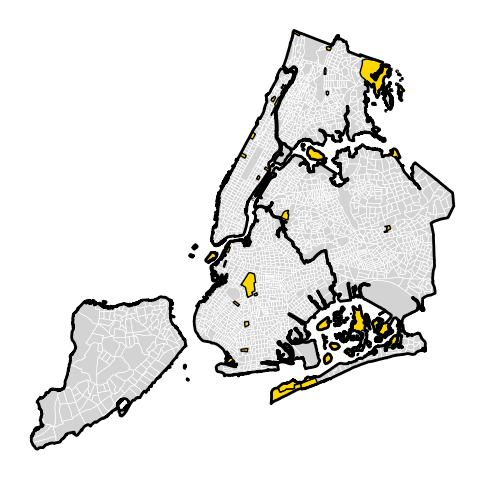

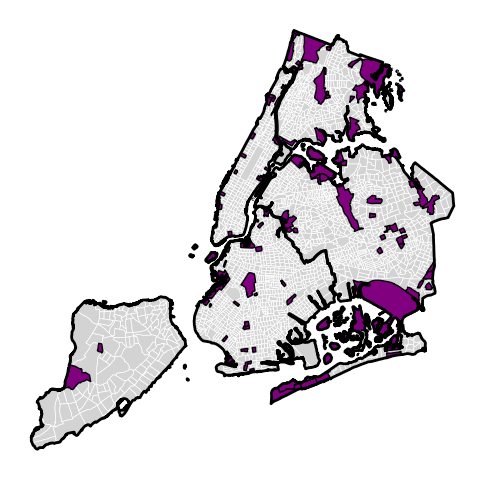

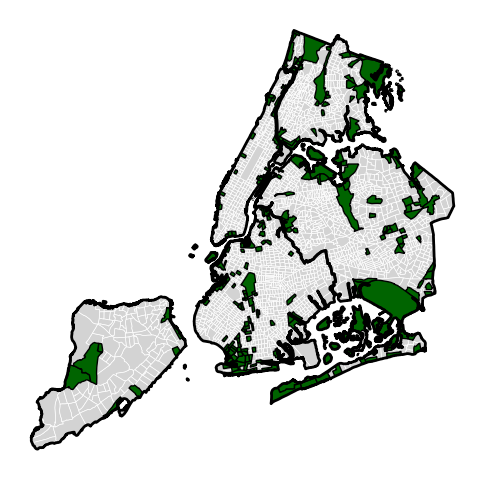

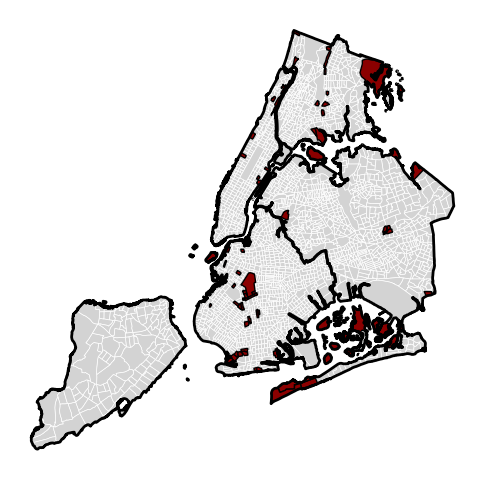

In [8]:
create_all_maps(analysis_df, estimate='p_y', figsize=(6, 6))